# Balun & Transformer Designs

This tutorial explains a few passive RF circuits, such as ferrite-loaded baluns & transformers using transmission lines, within the scikit-rf environment.  We tested these circuits in Windows Anaconda, Android Pydroid 3 and iOS Juno.

Baluns are balanced-to-unbalanced circuits. In other words, baluns convert differential to single-ended cicruits, and vice versa.

Transformers, as the name indicates, transform one RF impedance to another.

Both baluns and transformers can be built using transmission lines or lumped elements. Baluns and transformers are used extensively, but not exclusively, in RF matching circuits, combiners, dividers, amplifiers, mixers. At times, baluns and transformers are used in antenna designs, antenna emulators and/or antenna tuners (aka couplers).


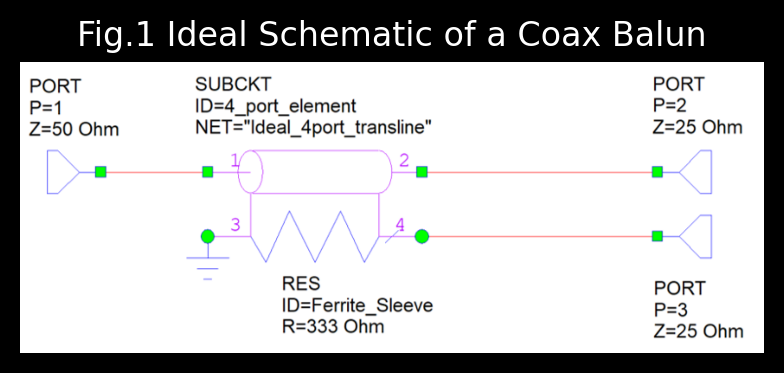

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
img=mpimage.imread('Simple_Balun2.bmp')
implot=plt.imshow(img)
plt.axis('off')
plt.title("Fig.1 Ideal Schematic of a Coax Balun")
plt.show()

In Fig.1 above, a coaxial balun is depicted and is comprised of a 4-port (outer conductor floating) coax and a resistor. In this circuit, the resistor is employed to model the effect of a ferrite sleeve (or bead) around the coax. The resistor acts to discourage current flow on the outside surface of the outer conductor, which makes the coax behave exactly like a twisted pair of wires over a bandwidth of interest. In some cases, a lumped inductor can replace the resistor to model the frequency-dependent behavior of the ferrite material of the sleeve. The actual value of the resistor, or the inductor, is a function of the frequency range of the design and the characteristics of the ferrite material. Often, the value of the resistor, or inductor, is derived from experimental measurements in the lab. We use 333-Ohms here as a reasonable value to demonstrate the usage of scikit-rf only.

In reality, a 4-port transmission line is implemented in scikit-rf exactly as shown in the nodal diagram of figure below:


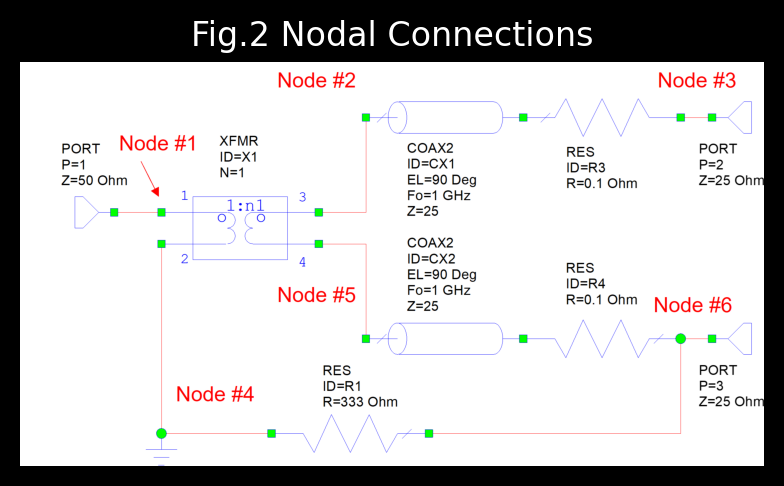

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
img=mpimage.imread('Nodal_Connections_Simple_Balun.bmp')
implot=plt.imshow(img)
plt.axis('off')
plt.title("Fig.2 Nodal Connections")
plt.show()

In [1]:
import matplotlib.pyplot as plt
import skrf as rf

rf.stylely()

Using Fig.2 as a guide, we can create a transmission-line balun as follows. First, we add some insertion loss to the trandmission lines in the firm of a 0.1-Ohm resistor.  Then we connect all the elements (transformer, two 25-Ohms lines and the ferrite resistor) together to create the balun.  The sum port is 50-Ohms single-ended.  The differential output ports are 25-Ohms each.

In [2]:
xformer = r"Ideal_4port_xformer_hi_res.s4p"  # need this ideal s4p file to create a coax with a floating outer conductor
xformer_ntwk = rf.Network(xformer)
xformer_ntwk1 = xformer_ntwk["0.001-2ghz"]  # band center is thus 1 GHz

freq = xformer_ntwk1.frequency
z0_ports = 25

beta = freq.w / rf.c
line_branch = rf.media.DefinedGammaZ0(frequency=freq, z0=z0_ports, gamma=0+beta*1j)

# d is 75 mm in length, which is quarterwave at 1 GHz in air
#d = line_branch.theta_2_d(90, deg=True, bc=True)
branch1 = line_branch.line(90, unit="deg", name="branch1")

lossy_line = line_branch.resistor(0.1, name="res")

The RF circuit is build using the scikit-rf [Circuit](https://scikit-rf.readthedocs.io/en/latest/tutorials/Circuit.html) capabilities:

In [3]:
port1 = rf.Circuit.Port(freq, name="port1", z0=25)
port2 = rf.Circuit.Port(freq, name="port2", z0=25)

# creating a 25-Ohm 2-port transmission line, with realistic insertion loss
# insertion loss is equivalent to a 0.1-Ohm series resistor
connections = [
    [(port1, 0), (lossy_line, 0)],
    [(lossy_line, 1), (branch1, 0)],
    [(branch1, 1), (port2, 0)],
]

C = rf.Circuit(connections)

line1 = C.network
line1.name = "top line"
line2 = C.network
line2.name = "bottom line"

line = rf.media.DefinedGammaZ0(frequency=freq, z0=50)
ferrite_resistor = line.resistor(333, name="res")

port1a = rf.Circuit.Port(frequency=freq, name="port1a", z0=50)
port2a = rf.Circuit.Port(frequency=freq, name="port2a", z0=25)
port3a = rf.Circuit.Port(frequency=freq, name="port3a", z0=25)
ground = rf.Circuit.Ground(frequency=freq, name="ground", z0=50)

# creating a 4-port floating coax by feeding two 25-Ohm lines (twisted pair of wires) with an ideal transformer, to ensure the differential nature of the twisted pair, as per Fig.2
# the 333-Ohm resistor models the loading of the ferrite sleeve, upon the outer conductor of the 4-port coax line
conn = [
    [(port1a, 0), (xformer_ntwk1, 0)],
    [(xformer_ntwk1, 1), (line1, 0)],
    [(line1, 1), (port2a, 0)],
    [(ground, 0), (xformer_ntwk1, 2), (ferrite_resistor, 0)],
    [(xformer_ntwk1, 3), (line2, 0)],
    [(line2, 1), (ferrite_resistor, 1), (port3a, 0)],
]

C1 = rf.Circuit(conn)
balun = C1.network
balun.name = "ideal balun"

Let's have a look the the S-parameters of this ideal balun:

Text(0.5, 0.98, 'Ideal 50-Ohm balun')

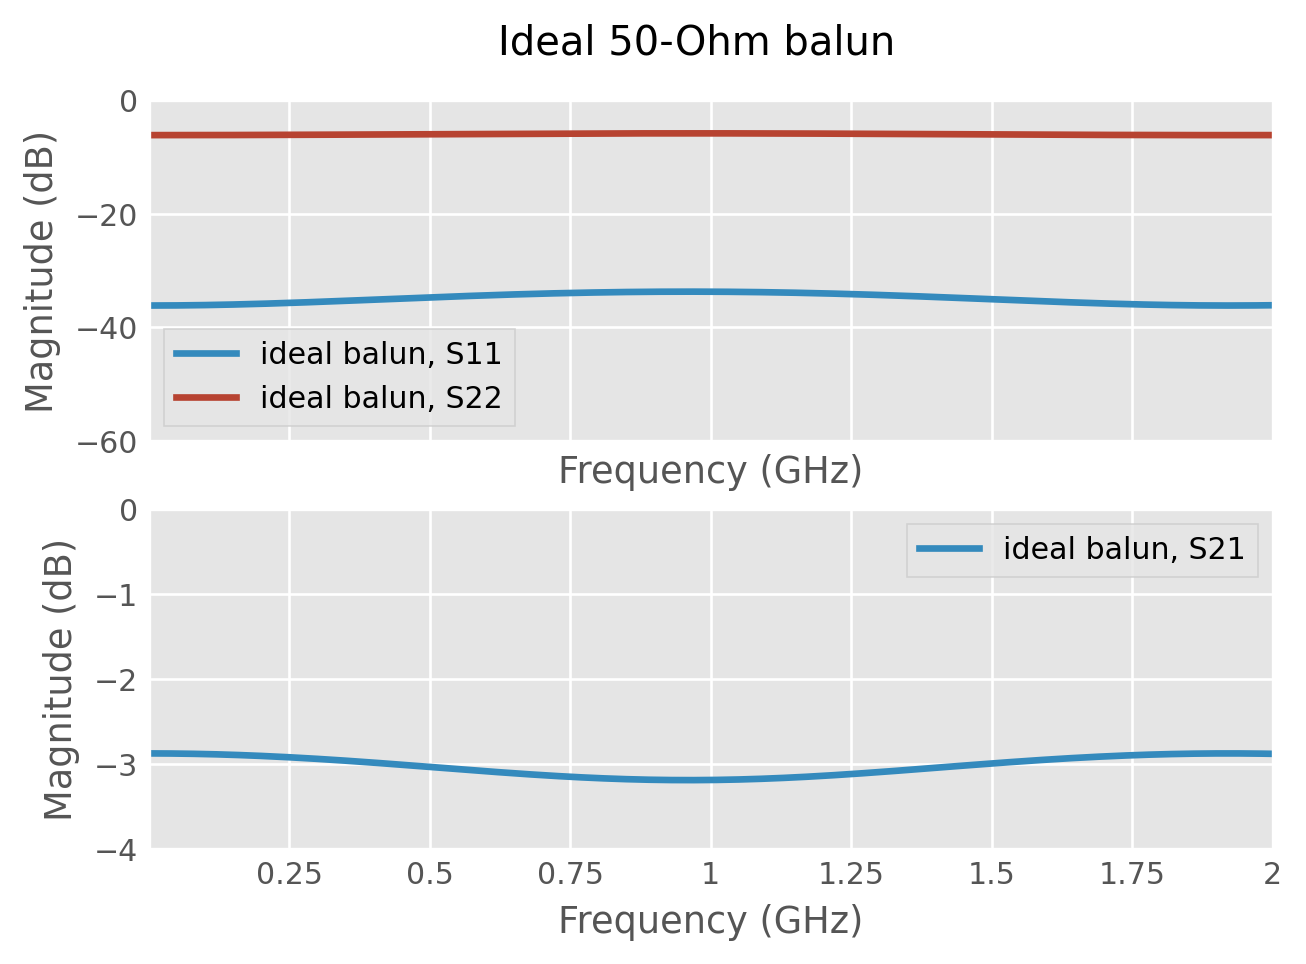

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

balun.plot_s_db(ax=ax1, m=0, n=0, lw=2)  # S11
balun.plot_s_db(ax=ax1, m=1, n=1, lw=2)  # S22
ax1.set_ylim(-60, 0)

balun.plot_s_db(ax=ax2, m=1, n=0, lw=2)  # S21
ax2.set_ylim(-4, 0)

fig.suptitle("Ideal 50-Ohm balun")

As can be seen from graph above, the sum port return loss S11 (blue trace, upper graph) is -35dB.  The S22 (red trace, upper graph) is -6dB, indicating the typical return loss of a terminal within a differential pair.  The S21 (blue trace, lower graph) is -3dB, as expected, to show that the energy entering the sum port splits evenly between the two differential ports.

The above example of a balun design was implemented in Scikit-rf version 1.3 (also compatible with earlier versions).  For Scikit-rf version 1.4, the script below employs a newly created element, called 'line_floating', to simplify the circuit.

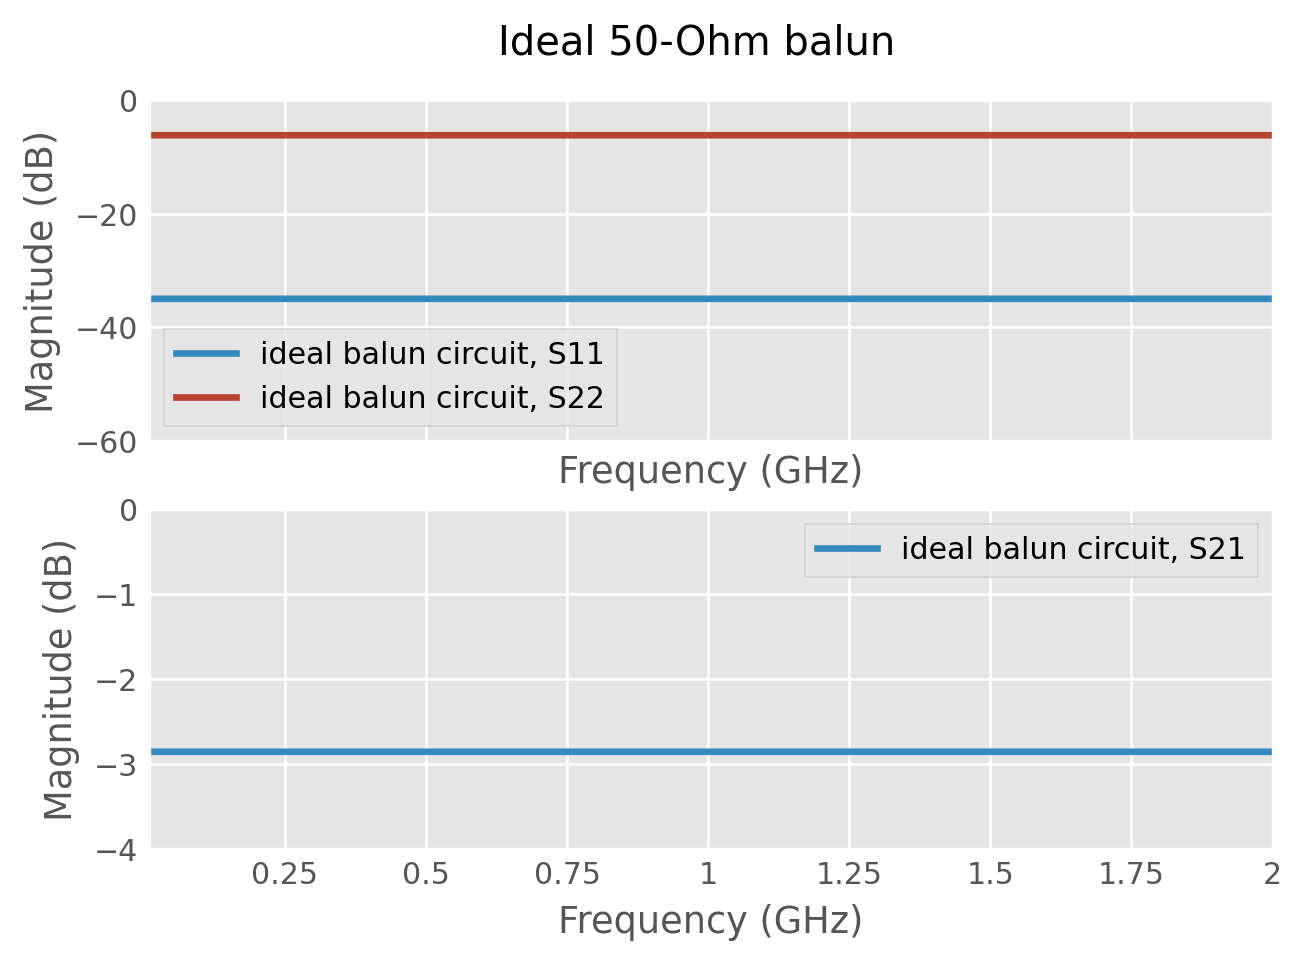

In [5]:

import skrf as rf
import matplotlib.pyplot as plt
rf.stylely()

freq1 = rf.Frequency(start=0.01, stop=2, unit=('GHz'), npoints=2001)

beta = freq1.w / rf.c

line1 = rf.media.DefinedGammaZ0(frequency=freq1, z0=50, gamma=0+beta*1j)
           
ferrite_resistor = line1.resistor(333, name='res') # model ferrite sleeve as a parallel 333 Ohm resistor
Rp_circuit = ferrite_resistor

# define a floating 4-port transmission line, using a new element in ver 1.4 of Scikit-rf

line4p = line1.line_floating(90, unit='deg', z0=50, name='line4p')

port1 = rf.Circuit.Port(frequency=freq1, name='port1', z0=50)
port2 = rf.Circuit.Port(frequency=freq1, name='port2', z0=25)
port3 = rf.Circuit.Port(frequency=freq1, name='port3', z0=25)
ground = rf.Circuit.Ground(frequency=freq1, name='ground', z0=50)

connections = [[(port1, 0), (line4p, 0)],
    [(port2, 0), (line4p, 1)],
    [(port3, 0), (line4p, 3), (Rp_circuit, 0)],
    [(line4p, 2), (Rp_circuit, 1), (ground, 0)]]

circuit = rf.Circuit(connections)
balun_circuit = circuit.network
balun_circuit.name = 'ideal balun circuit'

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

balun_circuit.plot_s_db(ax=ax1, m=0, n=0, lw=2)  # S11
balun_circuit.plot_s_db(ax=ax1, m=1, n=1, lw=2)  # S22
ax1.set_ylim(-60, 0)

balun_circuit.plot_s_db(ax=ax2, m=1, n=0, lw=2)  # S21
ax2.set_ylim(-4, 0)

fig.suptitle("Ideal 50-Ohm balun")

plt.show()

The next circuit to be explored is a Guanella transfomer, which is a 4-to-1 impedance transformer.  In this example, a 100-Ohms impedance is transformed to 25-Ohms using two 50-Ohms transmission lines.  This example is implemented in Scikit-rf version 1.4.


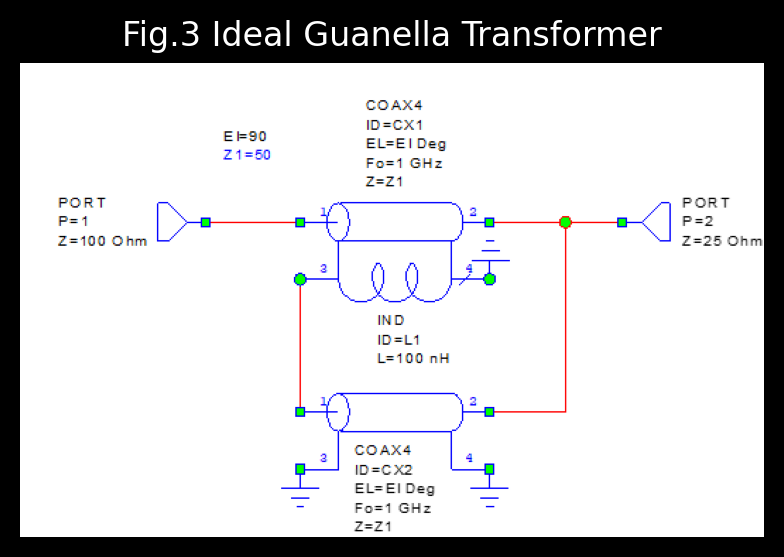

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
img=mpimage.imread('Guanella_transformer_1.bmp')
implot=plt.imshow(img)
plt.axis('off')
plt.title("Fig.3 Ideal Guanella Transformer")
plt.show()

Using Fig.3 as a nodal guide, a Guanella transformer can be created.  Note that on the left-hand side of the circuit, the two transmission lines are connected in RF series to form the 100-Ohms port.  On the opposite end, the right-hand side is connected in parallel to form the 25-Ohms port.  Also, the ferrite sleeve is modeled as an inductor in this example.

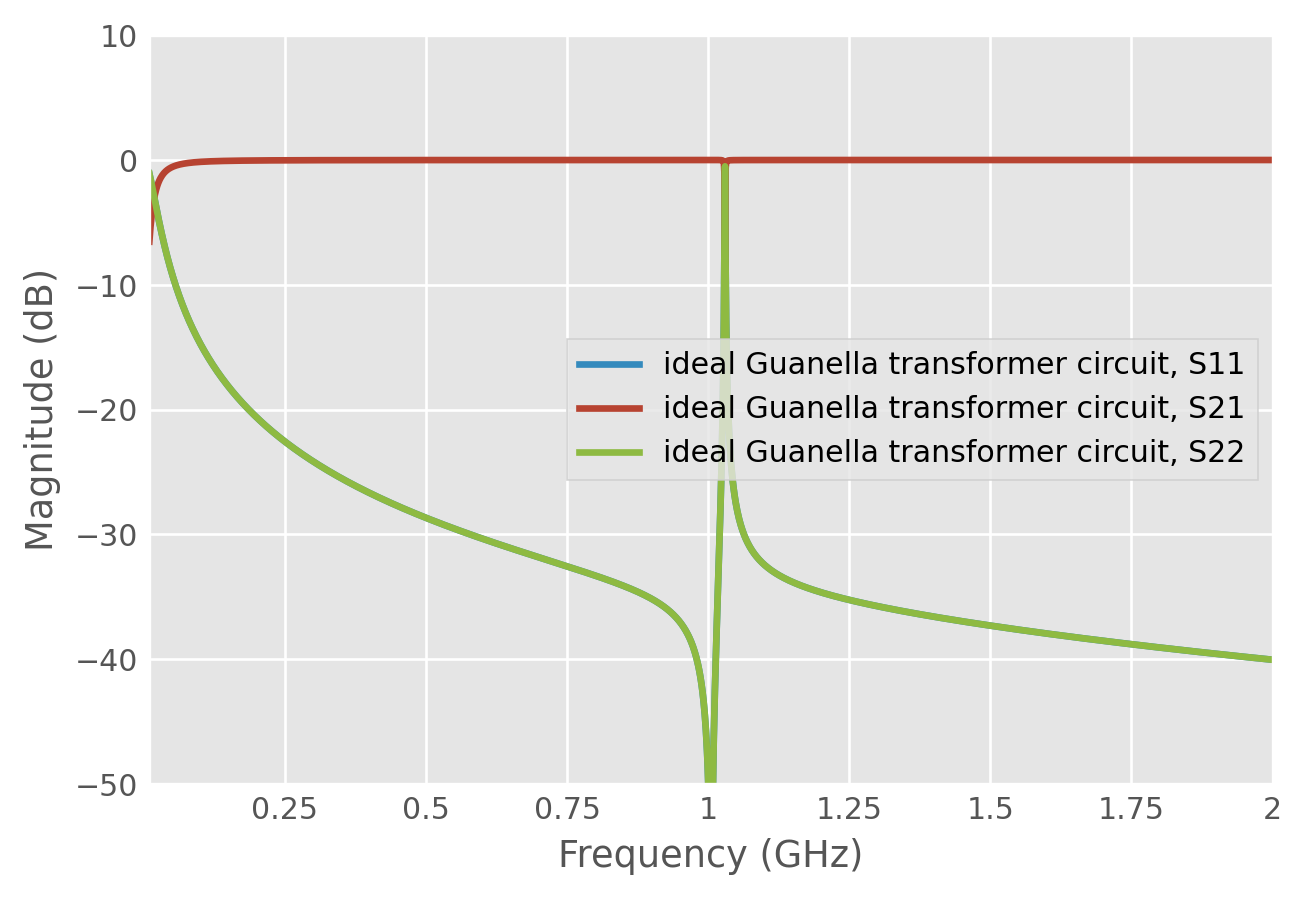

In [6]:
import skrf as rf
import matplotlib.pyplot as plt
rf.stylely()

freq = rf.Frequency(start=0.01, stop=2, unit=('GHz'), npoints=2001)

beta = freq.w/rf.c

line = rf.media.DefinedGammaZ0(frequency=freq, z0=50, gamma=0+beta*1j)
           
ferrite_inductor = line.inductor(100e-9, name='ind') # model ferrite sleeve as a parallel 100 nH inductor

# define a floating 4-port transmission line

line4p_a = line.line_floating(90, unit='deg', z0=50, name='line4p_a')

line4p_b = line.line_floating(90, unit='deg', z0=50, name='line4p_b')

port1 = rf.Circuit.Port(frequency=freq, name='port1', z0=100)
port2 = rf.Circuit.Port(frequency=freq, name='port2', z0=25)
ground1 = rf.Circuit.Ground(frequency=freq, name='ground1', z0=50)
ground2 = rf.Circuit.Ground(frequency=freq, name='ground2', z0=50)

connections = [[(port1, 0), (line4p_a, 0)],
    [(port2, 0), (line4p_a, 1), (line4p_b, 1)],
    [(line4p_a, 2), (line4p_b, 0), (ferrite_inductor, 0)],
    [(line4p_a, 3), (ferrite_inductor, 1), (ground1, 0), (line4p_b, 3)],
    [(line4p_b, 2), (ground2, 0)]]

circuit = rf.Circuit(connections)
transf_circuit = circuit.network
transf_circuit.name = 'ideal Guanella transformer circuit'

transf_circuit.plot_s_db(m=0, n=0, lw=2)
transf_circuit.plot_s_db(m=1, n=0, lw=2)
transf_circuit.plot_s_db(m=1, n=1, lw=2)

plt.ylim(-50,10)

plt.show()

In this Guanella transformer example, the ferrite sleeve is modeled as an inductor shunting across the outer conductor of the upper coax.  As can be seen in the S-parameter plot immediately above, the transformer works well between 200 and 1000 MHz.  Below 200 MHz, the ferrite-sleeve inductor does not provide enough impedance to "choke" to coax line properly.  At 1000 MHz, this circuit has a sharp resonance which constrains the upper frequency limit to 1 GHz.

The final circuit that we discuss here is the triax Marchand balun, which does not employ any ferrite material.  In this circuit, two triax sections are cascaded and the balanced output is taken from the middle.   Fig.4 shows a sketch of a Marchand balun, as per the description in the original Marchand's paper.


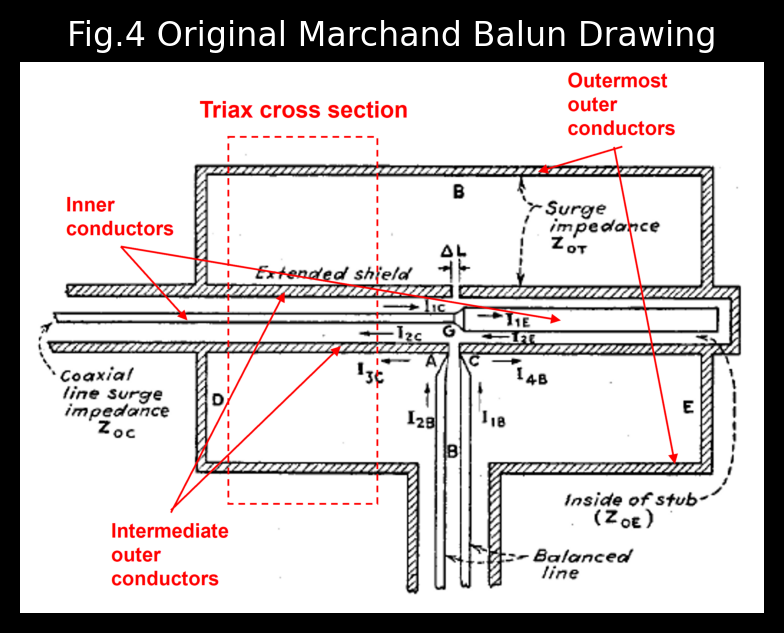

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
img=mpimage.imread('Annotated_Marchand.bmp')
implot=plt.imshow(img)
plt.axis('off')
plt.title("Fig.4 Original Marchand Balun Drawing")
plt.show()

As can be seen in Fig.4, the triax cross section has an inner conductor that is shielded by an intermediate circular outer conductor.  In turn, the circular outermost outer conductor envelopes the intermediate conductor.

Fig.5 Shows an electrical circuit which models the triax Marchand balun.  Two nested coax lines are employed to emulate one triax structure.  


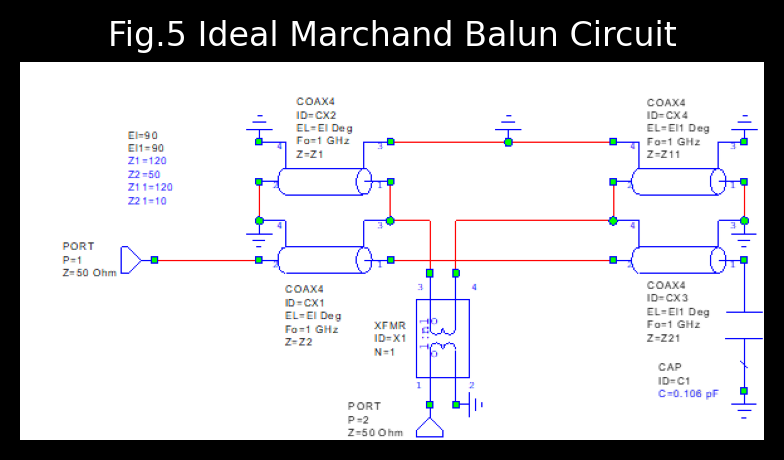

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
img=mpimage.imread('Marchand_Balun.bmp')
implot=plt.imshow(img)
plt.axis('off')
plt.title("Fig.5 Ideal Marchand Balun Circuit")
plt.show()

As seen in Fig.5, coax CX1 and CX2 form the first triax.  The inner most coax impedance CX1 is 50-Ohms.  The outer conductor of CX1 becomes the inner conductor of the 120-Ohms CX2.

The second triax is formed by the 10-Ohms CX3 and the 120-Ohms CX4.  Similar to the previous triax, the outer conductor of CX3 becomes the inner conductor of CX4.

The ideal transformer in Fig.5 is needed to show that the output of the Marchand balun is indeed differential.

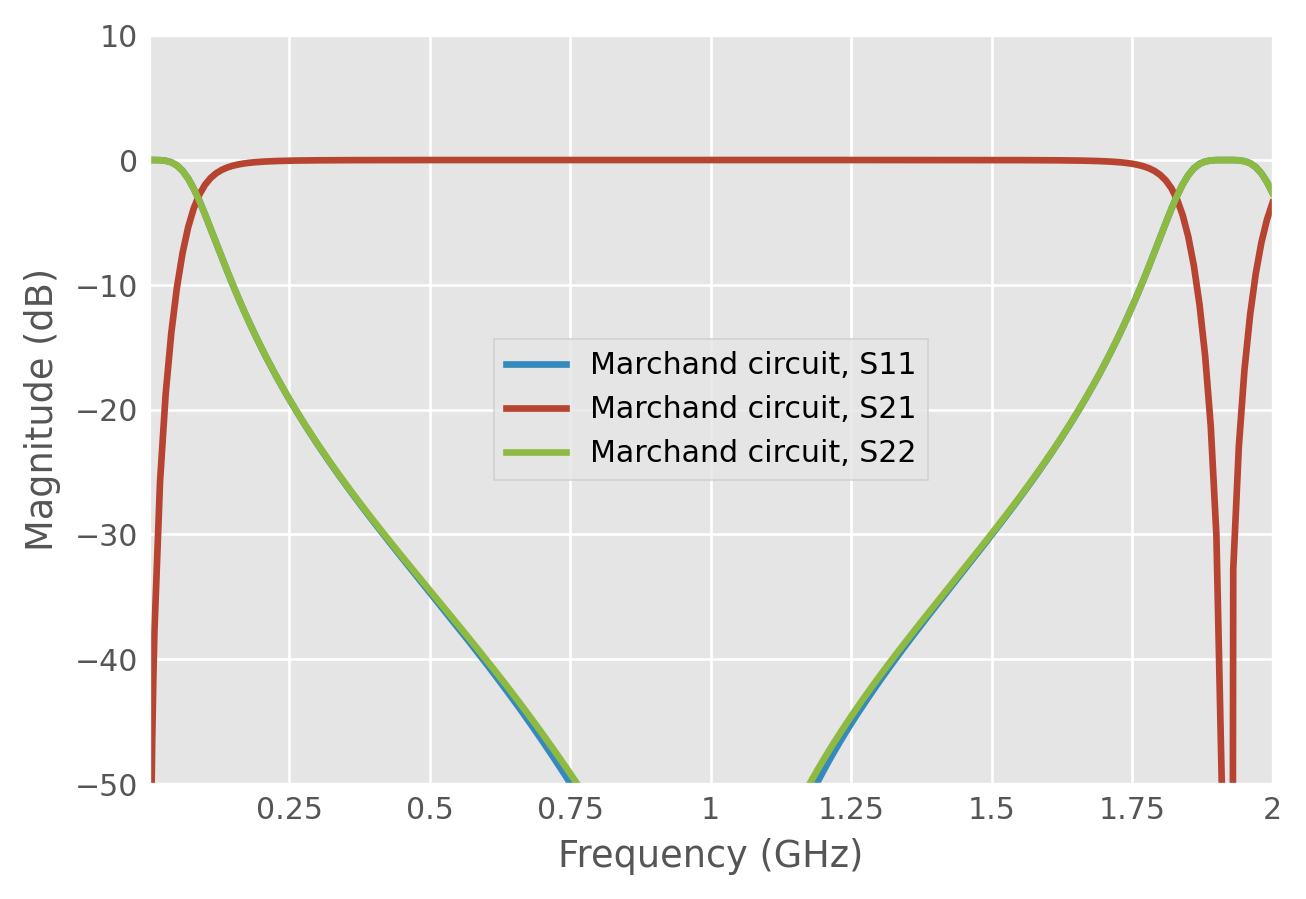

In [7]:
import skrf as rf
import matplotlib.pyplot as plt
rf.stylely()

xformer = r"Ideal_4port_xformer_hi_res.s4p"  # ideal transformer to convert differential ports to 50-Ohms single-ended

xformer_ntwk = rf.Network(xformer)
xformer_ntwk1a = xformer_ntwk["0.001-2ghz"]

freq = xformer_ntwk1a.frequency

beta = freq.w/rf.c

line = rf.media.DefinedGammaZ0(frequency=freq, z0=50, gamma=0+beta*1j)
           
C1 = line.capacitor(0.106e-12, name='cap')

# define a floating 4-port transmission line

line4p_a1 = line.line_floating(90, unit='deg', z0=50, name='line4p_a1')

line4p_b1 = line.line_floating(90, unit='deg', z0=120, name='line4p_b1')

line4p_c1 = line.line_floating(90, unit='deg', z0=10, name='line4p_c1')

line4p_d1 = line.line_floating(90, unit='deg', z0=120, name='line4p_d1')

port1a = rf.Circuit.Port(frequency=freq, name='port1', z0=50)
port2a = rf.Circuit.Port(frequency=freq, name='port2', z0=50)
ground1a = rf.Circuit.Ground(frequency=freq, name='ground1', z0=50)
ground2a = rf.Circuit.Ground(frequency=freq, name='ground2', z0=50)

connections = [[(port1a, 0), (line4p_a1, 0)],
    [(ground1a, 0), (line4p_a1, 2), (line4p_b1, 0), (line4p_b1, 2), (line4p_b1, 3)],
    [(line4p_a1, 1), (line4p_c1, 0)],
    [(line4p_a1, 3), (line4p_b1, 1), (xformer_ntwk1a, 0)],
    [(line4p_c1, 2), (xformer_ntwk1a, 2), (line4p_d1, 0)],
    [(line4p_d1, 1), (line4p_c1, 3), (line4p_d1, 2), (line4p_d1, 3), (C1, 1), (xformer_ntwk1a, 3), (ground2a, 0)],
    [(line4p_c1, 1), (C1, 0)],
    [(xformer_ntwk1a, 1), (port2a, 0)]]

circuit1 = rf.Circuit(connections)
Marchand_circuit = circuit1.network
Marchand_circuit.name = 'Marchand circuit'

Marchand_circuit.plot_s_db(m=0, n=0, lw=2)
Marchand_circuit.plot_s_db(m=1, n=0, lw=2)
Marchand_circuit.plot_s_db(m=1, n=1, lw=2)

plt.ylim(-50,10)

plt.show()

In the S-parameter plot of the Marchand balun above, the bandwidth of this circuit is from 250 to 1600 MHz (-20dB return-loss bandwidth).  This multi-octave performance is achieved without the use of any ferrite sleeve.  The compromise here is the complexity of the balun's construction.

Using these three simple examples, one can build many other interesting transmission-line circuits in Scikit-rf.  Furthermore, these circuits can be built on an iphone (Juno), or an Android tablet (Pydroid 3), or a laptop (Anaconda).  Such ease of access allows design ideas to be quickly & accurately captured and tested where or whenever they are conceived.  The possibilities and potentials are endless.

Created by:
Ky-Hien Do  -  kyhiendo@hydrawave.com
James Melley  -  jmelley@werlatone.com
Jared Schwarz  -  jschwarz@werlatone.com